In [1]:
# Configuración inicial
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import yaml
from omegaconf import OmegaConf
from hydra import initialize, compose

# Configurar PROJECT_ROOT y agregar al PYTHONPATH
PROJECT_ROOT = Path.cwd().parent if "notebooks" in str(Path.cwd()) else Path.cwd()
os.environ["PROJECT_ROOT"] = str(PROJECT_ROOT)

# Agregar el directorio raíz al PYTHONPATH
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

%matplotlib inline

# Inicializar Hydra y cargar configuración
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="main")

# Proyección y Visualización de Población Departamental

Esta celda realiza dos operaciones principales:

## 1. Cálculo de Proyecciones
Utilizamos la función `project_population` para generar proyecciones poblacionales por departamento:
- Usa datos censales de 1996, 2011 y 2023 como puntos de referencia
- Realiza interpolación lineal entre años censales
- Aplica extrapolación exponencial para años fuera del rango censal
- Convierte todos los valores a números enteros
- Guarda los resultados en la carpeta `estimated` con sus metadatos

Proyectando población departamental...


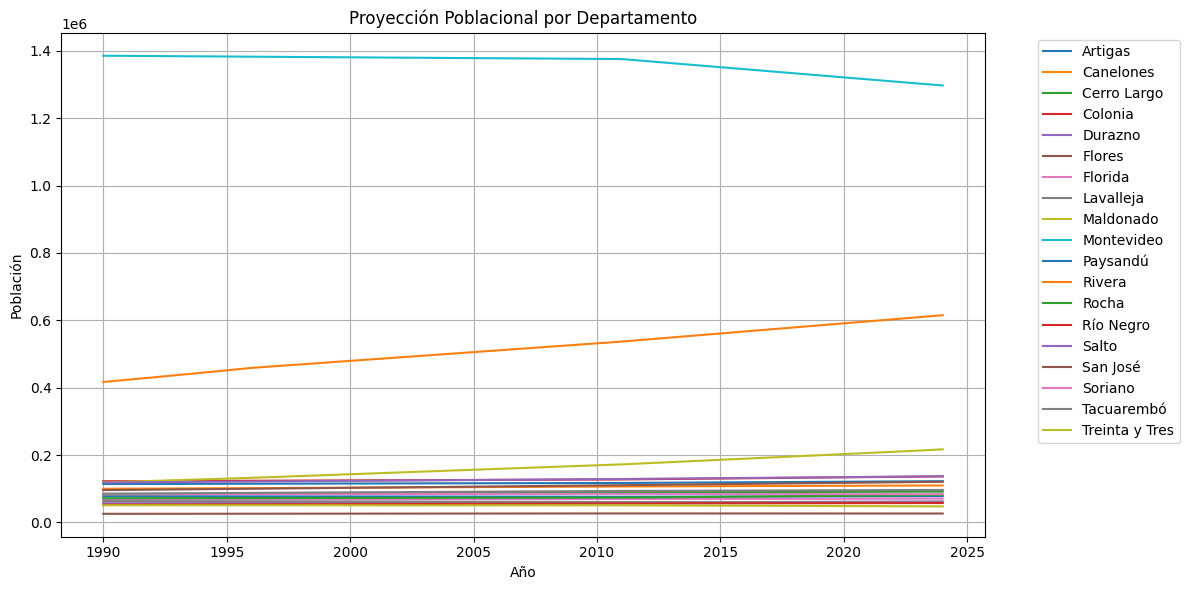

In [2]:
# Ahora podemos usar la proyección
from src.estimators import population as pop_estimator

# Ejecutar proyección usando rutas completas
poblacion_df, metadata = pop_estimator.project_population(
    input_path=os.path.join(cfg.paths.raw_dir, cfg.data.raw.population_census.file),
    output_path=os.path.join(cfg.paths.estimated_dir, cfg.data.estimated.projected_population.file),
    years_params=cfg.params.years
)

# Visualizar resultados
plt.figure(figsize=(12, 6))
for depto in poblacion_df.columns:
    plt.plot(poblacion_df.index, poblacion_df[depto], label=depto)

plt.title('Proyección Poblacional por Departamento')
plt.xlabel('Año')
plt.ylabel('Población')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Proyección y Visualización de la Participación Departamental en el PIB

Esta _celda_ ejecuta el proceso integral para estimar y proyectar la participación de cada departamento en el Producto Interno Bruto (PIB) nacional, combinando datos históricos de participación y proyecciones de población. A continuación, se describe el flujo de trabajo de manera detallada:

---

### 1. Entrada y Validación de Datos

1. **Datos de Participación**  
   - Se carga un archivo CSV que contiene la participación de cada departamento en el PIB, generalmente disponible para los años 2008 a 2014.  
   - Se validan estos datos para asegurar que existan las columnas necesarias y que no se encuentren vacíos.

2. **Proyecciones Poblacionales**  
   - Se carga un archivo CSV con la proyección de población por departamento, indexado por año (1990–2024).  
   - Se verifica que la estructura de columnas y el índice de años sean correctos para el posterior cálculo de proporciones.

---

### 2. Construcción del Panel de Datos

1. **Cálculo de la Proporción Poblacional**  
   - Para cada año, se suma la población de todos los departamentos y se obtiene la proporción correspondiente a cada uno:
     \[
       \text{ratio}_{d,t} = \frac{\text{población}_{d,t}}{\sum_d \text{población}_{d,t}}
     \]
2. **Integración de Variables en un Panel**  
   - Se combina la proporción poblacional (`ratio`) con la participación histórica disponible (`participacion`), creando un _panel_ de datos que contiene \[departamento, año, ratio, participacion\] únicamente en los años donde se dispone de datos observados.

---

### 3. Ajuste del Modelo de Panel (Efectos Fijos)

1. **Especificación del Modelo**  
   - Se utiliza una regresión con efectos fijos por departamento mediante la fórmula:
     ```none
     participacion ~ C(departamento) + ratio - 1
     ```
     donde:
     - `C(departamento)` crea un intercepto distinto para cada departamento (efecto fijo).
     - `ratio` es la proporción poblacional calculada en el paso anterior.
     - `- 1` elimina el intercepto global, de modo que cada departamento tenga el suyo.

2. **Estimación**  
   - Se ajusta el modelo usando Mínimos Cuadrados Ordinarios (OLS) y se obtienen los parámetros estimados (uno por departamento y uno común para `ratio`).

3. **Resumen del Modelo**  
   - Se genera un reporte con estadísticas clave (R², p-valores, etc.) para evaluar el ajuste.

---

### 4. Proyección para el Rango Completo

1. **Aplicación del Modelo**  
   - Empleando los coeficientes estimados, se proyecta la participación desde 1990 hasta 2024, aprovechando que se dispone de la proporción poblacional (`ratio`) en esos años.

2. **Clipping de Valores**  
   - Se aplican límites para descartar valores extremos (por ejemplo, fijar un mínimo y un máximo razonables para la participación proyectada).

---

### 5. Reinserción y Normalización de Datos

1. **Reinserción de Datos Históricos**  
   - En los años con observaciones reales (por ejemplo, 2008–2014), se reinsertan los valores empíricos de participación, reemplazando la predicción del modelo.  
   - Esto asegura que la serie respete los datos observados en lugar de los estimados.

2. **Normalización a 100%**  
   - Finalmente, se normalizan las participaciones de cada año para que la suma de todos los departamentos sea exactamente 100%.  
   - Esto garantiza coherencia en la interpretación del reparto porcentual del PIB.

---

Al final, el DataFrame resultante mostrará la participación proyectada de cada departamento para todos los años especificados (1990–2024, o el rango elegido), incorporando los valores reales en los años en que se dispone de datos observados y asegurando la suma al 100% anual.


Proyectando participación departamental en PIB con modelo de panel (efectos fijos)...
Datos de participación cargados y validados desde: c:\Users\trico\OneDrive\UBA\Evaluacion de PP basado en evidencia\Investigacion\sucive/data/processed\subnational_gdp_share/subnational_gdp_share_processed.csv
Datos de población cargados desde: c:\Users\trico\OneDrive\UBA\Evaluacion de PP basado en evidencia\Investigacion\sucive/data/estimated\projected_population/projected_population.csv
Panel construido con 133 filas.

Resumen del modelo (panel con efectos fijos por dpto + ratio):

                            OLS Regression Results                            
Dep. Variable:          participacion   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.818e+04
Date:                Sat, 15 Feb 2025   Prob (F-statistic):          2.71e-198
Time:                        1

<Figure size 1200x600 with 0 Axes>

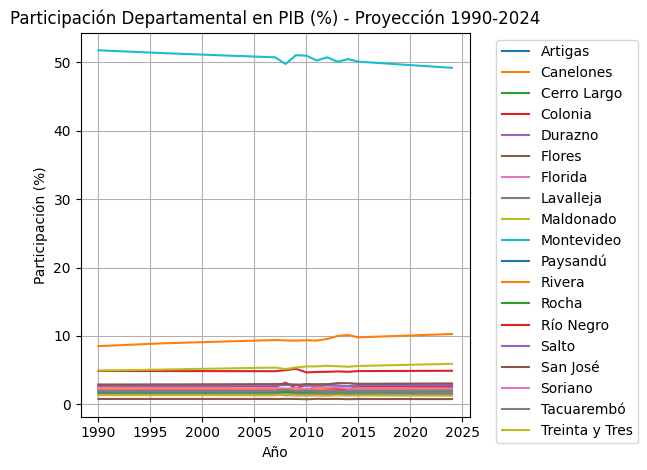

In [3]:
from src.estimators import subnational_gdp_share

# Proyectar participación departamental en PIB
gdp_share_df, gdp_share_metadata = subnational_gdp_share.project_subnational_gdp_share(
    input_path= os.path.join(cfg.paths.processed_dir, cfg.data.processed.subnational_gdp_share.file),
    population_path=os.path.join(cfg.paths.estimated_dir, cfg.data.estimated.projected_population.file),
    output_path=os.path.join(cfg.paths.estimated_dir, cfg.data.estimated.projected_subnational_gdp_share.file),
    years_params=cfg.params.years
)

# Visualizar resultados
plt.figure(figsize=(12, 6))
gdp_share_df.plot(grid=True)
plt.title('Participación Departamental en PIB (%) - Proyección 1990-2024')
plt.xlabel('Año')
plt.ylabel('Participación (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Estimación y Visualización del PIB Departamental

Este análisis genera una estimación del Producto Interno Bruto (PIB) a nivel departamental para Uruguay, combinando dos fuentes principales:

1. **Participación departamental en el PIB nacional**
   - Proyecciones basadas en datos históricos 2008-2014
   - Ajustadas por tendencias poblacionales
   - Normalización para asegurar suma del 100%

2. **PIB nacional en dólares constantes**
   - Serie histórica 1990-2024
   - Valores ajustados a precios de 2020
   - Fuente: Banco Mundial

La visualización se presenta en dos formatos complementarios:

- **Gráfico de líneas**: Muestra la evolución temporal del PIB de cada departamento, permitiendo identificar tendencias, convergencias y divergencias en el desarrollo económico regional.

- **Gráfico circular**: Representa la distribución actual del PIB entre departamentos, destacando las asimetrías en la concentración de la actividad económica.

⚠️ **Nota**: Las estimaciones para períodos sin datos observados se basan en modelos estadísticos que consideran la estructura económica histórica y la dinámica poblacional.


Estimando PIB departamental...

Validación de totales:
      sum_departamentos  pib_nacional
1990       9.298808e+09  9.298808e+09
1991       1.120618e+10  1.120618e+10
1992       1.287815e+10  1.287815e+10
1993       1.500214e+10  1.500214e+10
1994       1.747459e+10  1.747459e+10
1995       1.929766e+10  1.929766e+10
1996       2.051546e+10  2.051546e+10
1997       2.396974e+10  2.396974e+10
1998       2.538589e+10  2.538589e+10
1999       2.398395e+10  2.398395e+10
2000       2.282327e+10  2.282327e+10
2001       2.089876e+10  2.089876e+10
2002       1.360652e+10  1.360652e+10
2003       1.204564e+10  1.204564e+10
2004       1.368633e+10  1.368633e+10
2005       1.736286e+10  1.736286e+10
2006       1.974142e+10  1.974142e+10
2007       2.379777e+10  2.379777e+10
2008       3.111960e+10  3.111960e+10
2009       3.270832e+10  3.270832e+10
2010       4.195036e+10  4.195036e+10
2011       5.034241e+10  5.034241e+10
2012       5.423227e+10  5.423227e+10
2013       6.133762e+10  6.13376

<Figure size 1200x600 with 0 Axes>

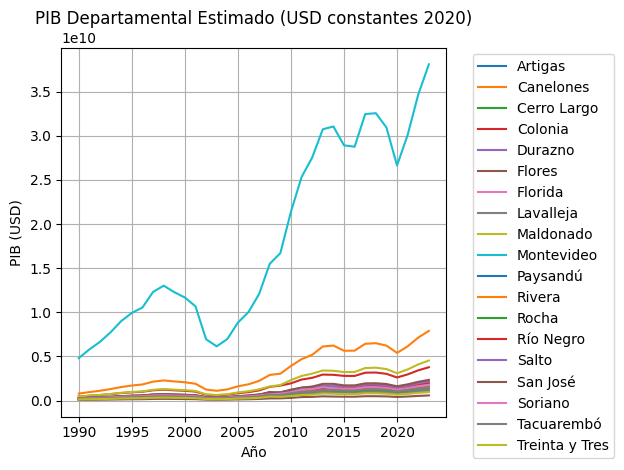

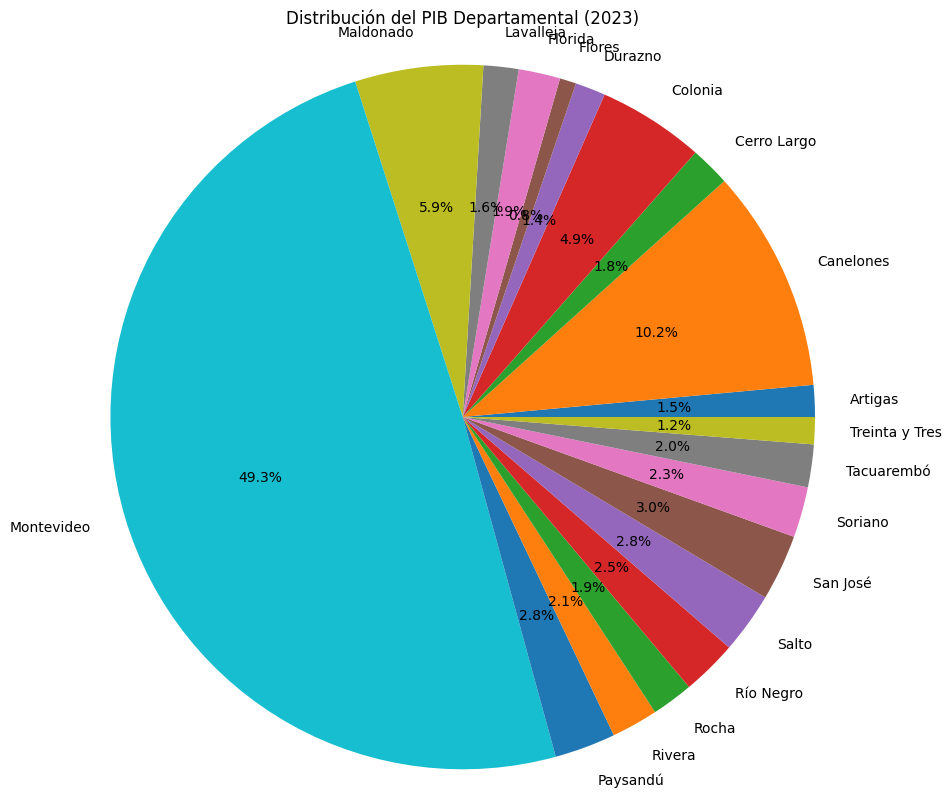

In [4]:
import src.estimators.subnational_gdp as economic

# Cargar y visualizar PIB departamental estimado
gdp_dept_df, gdp_dept_metadata = economic.estimate_subnational_gdp(
    gdp_share_path=os.path.join(cfg.paths.estimated_dir, cfg.data.estimated.projected_subnational_gdp_share.file),
    national_gdp_path=os.path.join(cfg.paths.processed_dir, cfg.data.processed.gdp.file),
    output_path=os.path.join(cfg.paths.estimated_dir, cfg.data.estimated.projected_subnational_gdp.file),
    years_params=cfg.params.years
)

# Visualizar evolución del PIB departamental
plt.figure(figsize=(12, 6))
gdp_dept_df.plot(grid=True)
plt.title('PIB Departamental Estimado (USD constantes 2020)')
plt.xlabel('Año')
plt.ylabel('PIB (USD)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Mostrar participación en último año
ultimo_ano = gdp_dept_df.index.max()
pie_data = gdp_dept_df.loc[ultimo_ano]

plt.figure(figsize=(10, 10))
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%')
plt.title(f'Distribución del PIB Departamental ({ultimo_ano})')
plt.axis('equal')
plt.show()

## Estimacion de recaudacion de patentes vehiculares para Montevideo periodo 1990-2006

Para este análisis utilizamos datos de múltiples fuentes:

1. **Recaudación de patentes vehiculares (2007-2024)**
   - Fuente: OPP Uruguay
   - Cobertura: Datos reales para todos los departamentos desde 2007
   - Unidad: Pesos uruguayos corrientes

2. **Población departamental (1990-2024)**
   - Fuente: INE Uruguay
   - Uso: Covariable para el control sintético
   - Notas: Interpolación entre censos

3. **IPC (1990-2024)**
   - Fuente: INE Uruguay
   - Base: 2020 = 100
   - Uso: Deflactación de valores nominales

4. **Tipo de cambio 2020**
   - Fuente: BCU Uruguay
   - Valor: 43.13 UYU/USD
   - Uso: Conversión a dólares constantes

---

### Solución Metodológica Transitoria

Ante la ausencia de datos históricos confiables de recaudación de patentes para Montevideo en el período pre-2007, implementamos una solución metodológica transitoria basada en control sintético.

#### Control Sintético con ElasticNet

1. **Fundamentos del método**
   - Construcción de un "Montevideo sintético" usando otros departamentos como donantes
   - Ponderación óptima de departamentos mediante ElasticNet
   - Validación cruzada temporal para robustez

2. **Especificación del modelo**
   - Variable objetivo: Recaudación de Montevideo (1990-2006)
   - Predictores: Recaudación de departamentos donantes
   - Covariables adicionales: Población departamental
   - Regularización: Combinación L1/L2 (ElasticNet)

#### Validación y Ajuste

1. **Métricas de ajuste**
   - R² = 0.929 en período de entrenamiento
   - Validación cruzada temporal (3 splits)
   - Selección automática de hiperparámetros

2. **Controles de calidad**
   - Transición suave en 2007
   - Consistencia con tendencias conocidas
   - Comportamiento plausible de elasticidades

---

### Limitaciones y Advertencias

1. **Naturaleza transitoria**
   - Solución temporal hasta obtener datos históricos reales
   - No reemplaza la importancia de recuperar datos originales
   - Útil para análisis preliminares y tendencias generales

2. **Supuestos clave**
   - Estabilidad en relaciones interdepartamentales
   - Ausencia de shocks específicos pre-2007
   - Patrones similares en departamentos donantes

3. **Recomendaciones de uso**
   - Enfocarse en tendencias más que valores puntuales
   - Documentar claramente naturaleza estimada de los datos
   - Actualizar cuando se obtengan datos históricos reales

---

### Documentación y Reproducibilidad

Toda la metodología, parámetros y resultados quedan documentados en archivos YAML que acompañan los datos, incluyendo:
- Metadata del procesamiento inicial
- Especificaciones del control sintético
- Pesos de departamentos donantes
- Métricas de ajuste
- Advertencias y limitaciones


Estimando control sintético para Montevideo...


c:\Users\trico\OneDrive\UBA\Evaluacion de PP basado en evidencia\Investigacion\sucive\src\estimators\vehicle_tax.py:75: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
c:\Users\trico\OneDrive\UBA\Evaluacion de PP basado en evidencia\Investigacion\sucive\src\estimators\vehicle_tax.py:108: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')


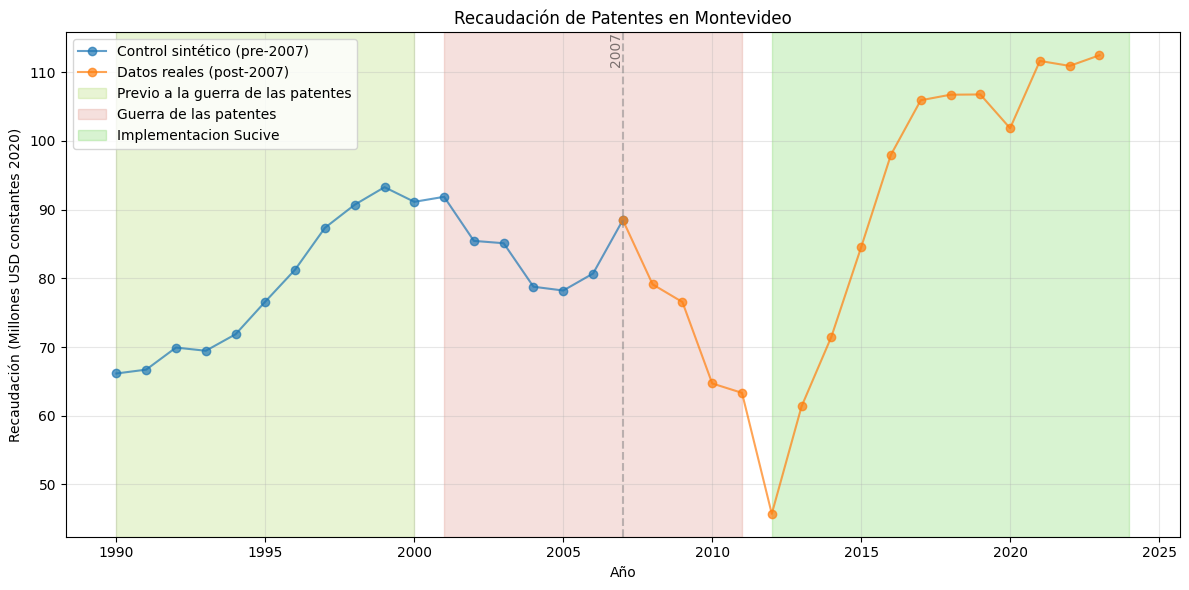

In [5]:
import src.estimators.vehicle_tax as estimate_taxes
import src.processors.taxes as taxes

# 1. Ejecutar estimación
df_estimated_vehicle_tax, metadata = estimate_taxes.estimate_missing_vehicle_tax(
    input_path=os.path.join(cfg.paths.processed_dir, cfg.data.processed.vehicle_tax.file),
    population_path=os.path.join(cfg.paths.estimated_dir, cfg.data.estimated.projected_population.file),
    output_path=os.path.join(cfg.paths.estimated_dir, cfg.data.estimated.estimated_montevideo_vehicle_tax.file),
    years_params=cfg.params.years,
    target_dept='Montevideo',
    treatment_year=2007
)

# 2. Crear dataset final usando los datos en memoria
df_final_vehicle_tax, metadata = taxes.create_final_vehicle_tax(
    original_path=os.path.join(cfg.paths.processed_dir, cfg.data.processed.vehicle_tax.file),
    estimated_path=os.path.join(cfg.paths.estimated_dir, cfg.data.estimated.estimated_montevideo_vehicle_tax.file),
    output_path=os.path.join(cfg.paths.final_dir, cfg.data.final.vehicle_tax.file),
    treatment_year=2007
)

# Preparar datos para visualización
montevideo_data = df_final_vehicle_tax[df_final_vehicle_tax['DEPARTAMENTO'] == 'Montevideo'].melt(
    id_vars=['DEPARTAMENTO'],
    var_name='año',
    value_name='recaudacion'
)
montevideo_data['año'] = pd.to_numeric(montevideo_data['año'])
montevideo_data = montevideo_data.sort_values('año')

# Convertir a millones de dólares
montevideo_data['recaudacion'] = montevideo_data['recaudacion'] / 1_000_000

# Crear figura
plt.figure(figsize=(12, 6))

# Definir colores consistentes
color_synthetic = '#1f77b4'  # azul original
color_real = '#ff7f0e'      # naranja original

# Graficar series ajustando el punto de corte
plt.plot(montevideo_data[montevideo_data['año'] <= 2007]['año'], 
         montevideo_data[montevideo_data['año'] <= 2007]['recaudacion'],
         'o-', color=color_synthetic, label='Control sintético (pre-2007)', alpha=0.7)

plt.plot(montevideo_data[montevideo_data['año'] >= 2007]['año'],
         montevideo_data[montevideo_data['año'] >= 2007]['recaudacion'],
         'o-', color=color_real, label='Datos reales (post-2007)', alpha=0.7)

# Agregar línea vertical en 2007
plt.axvline(x=2007, color='gray', linestyle='--', alpha=0.5)
plt.text(2007, plt.ylim()[1], '2007', rotation=90, 
         va='top', ha='right', alpha=0.5)

# Agregar periodos
# Definir periodos históricos
periods = [
    {'start': 1990, 'end': 2000, 'label': 'Previo a la guerra de las patentes', 'color': '#8DC92CFF', 'alpha': 0.2},
    {'start': 2001, 'end': 2011, 'label': 'Guerra de las patentes', 'color': '#CF6456FF', 'alpha': 0.2}, 
    {'start': 2012, 'end': 2024, 'label': 'Implementacion Sucive', 'color': '#3DC41C9F', 'alpha': 0.2}
]

# Agregar sombreado para cada periodo
for period in periods:
    plt.axvspan(period['start'], period['end'], 
                color=period['color'], 
                alpha=period['alpha'],
                label=period['label'])


# Configurar gráfico
plt.xlabel('Año')
plt.ylabel('Recaudación (Millones USD constantes 2020)')
plt.title('Recaudación de Patentes en Montevideo')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()